# Assignment 2 Brief 

## Deadline: Tuesday, December 3, 2019 at 14:00 hrs

## Number of marks available: 20

## Scope: Sessions 6 to 9

## 1. Instructions
### How and what to submit

A. Submit a Jupyter Notebook named COM4509-6509_Assignment_2_UCard_XXXXXXXXX.ipynb where XXXXXXXXX refers to your UCard number.

B. Upload the notebook file to MOLE before the deadline above.

C. **NO DATA UPLOAD**: Please do not upload the data files used. We have a copy already. 


### Assessment Criteria 

* Being able to manipulate a dataset by generating sythetic data and extracting a particular subset. 

* Being able to build and train different machine learning models with tunable hyperparameters to optimise given evaluation metric.

* Being able to compare different machine learning models and explain interesting results observed. 

* Being able to follow examples in the lab and write code without the help of starter code.


### Late submissions

We follow Department's guidelines about late submissions, i.e., a deduction of 5% of the mark each working day the work is late after the deadline. NO late submission will be marked one week after the deadline because we will release a solution by then. Please read [this link](https://sites.google.com/sheffield.ac.uk/compgtstudenthandbook/menu/assessment/late-submission?pli=1&authuser=1). 

### Use of unfair means 

**"Any form of unfair means is treated as a serious academic offence and action may be taken under the Discipline Regulations."** (from the MSc Handbook). Please carefully read [this link](https://sites.google.com/sheffield.ac.uk/compgtstudenthandbook/menu/referencing-unfair-means?pli=1&authuser=1) on what constitutes Unfair Means if not sure.

# 2. Image classification and denoising

### The CIFAR-10 dataset
In this assignment, we will work on the [**CIFAR-10 dataset**](https://www.cs.toronto.edu/~kriz/cifar.html) collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton from the University of Toronto.  This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Each image is a 3-channel colour images of 32x32 pixels in size. There are 50000 training images and 10000 test images. 

			
### Question 1: Data loading and manipulation (4 marks)

1a. **Download** both the training and test data of the CIFAR-10 dataset, e.g., by following the [pytorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). You can also download via other ways if you prefer.

1b. **Add random noise** to all training and test data to generate noisy dataset, e.g., by `torch.randn()`, with a scaling  factor `scale`, e.g., original image `+ scale * torch.randn()`, and **normalise/standardise** the pixel values to the **original range**, e.g.,  using `np.clip()`. You may choose any `scale` value between 0.2 and 0.5. 

**Note: Before generating the random noise, you MUST set the random seed to your UCard number XXXXXXXXX for reproducibility, e.g., using `torch.manual_seed()`. This seed needs to be used for all remaining code if there is randomness, for reproducibility.**

1c. **Extract a subset** with only two classes: **Cat** and **Dog** and name it starting with **CatDog**.        

1d. Show 10 pairs of original and noisy images of cats and 10 pairs of original and noisy images of dogs.

#### Question 1 Answer

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
raw


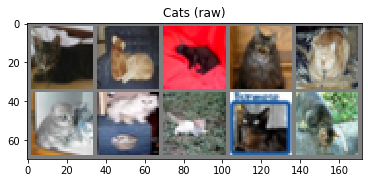

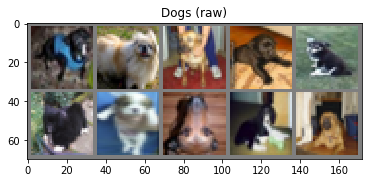

noise


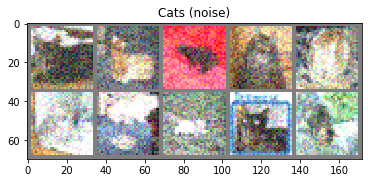

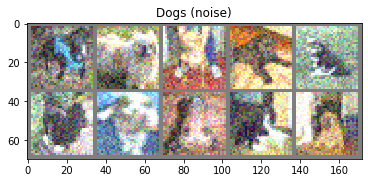

In [2]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression

torch.manual_seed(1720410)
IMAGE_SIZE = torch.Size([3,32,32])
NOISE = torch.rand(IMAGE_SIZE)
SCALE = 0.4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH = 8 if device == torch.device("cpu") else 200

# %% Q1
class CIFAR10Dataset(torch.utils.data.Dataset):
    '''CIFAR10Dataset

    Custom data collection loading method. Extract data from selected labels only.
    For example:
        target_classes  = ('cat','dog') # Extract cat and dog data
        target_classes  = ('cat','dog','bird','ship') # Extract cat, dog, bird and ship data

    '''
    def __init__(self, target_classes, root='./data', train=True, download=True, transform=None):
        self.images = list()
        self.labels = list()
        self.root = root
        self.train = train
        self.download = download
        self.transform = transform
        self.__loaddata(target_classes)
        self.normal_images = torch.clamp(self.NormalizeALL(),-1,1)
        self.length = self.__len__()
        assert len(self.images) == len(self.labels)

    def __loaddata(self, target_classes):
        dataset = torchvision.datasets.CIFAR10(
            root=self.root, train=self.train, download=self.download, transform=None)
        classes = ('plane', 'car', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        labels = np.array(dataset.targets)
        mask = np.zeros(len(labels)) == 1
        for item in target_classes:
            mask |= (labels == classes.index(item))
        mask = np.where(mask)
        self.labels = list(map(lambda x: target_classes.index(classes[x]),labels[mask]))
        self.images = dataset.data[mask]

    # Normalize all the dataset
    def NormalizeALL(self):
        normal = torch.zeros(self.images.shape[0],*IMAGE_SIZE)
        for i in range(self.images.shape[0]):
            normal[i] = self.transform(self.images[i])
        return normal

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return torch.clamp(image,-1,1), label

# show images from pytorch loader
def imshow(img,title = None,size = None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# basic parameters
classes = ('cat', 'dog')
data_source = {'train':True,'test':False}
data_process = ('raw','noise')

# set transform for dataset
transform = {
    'raw': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'noise': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + SCALE * NOISE),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])}
# load 4 different datasets:
# train with raw data, train with noise data
# test with raw data, test with noise data
CatDog = dataset = {k: {p: CIFAR10Dataset(classes, root='./data', train=v,
                    download=True, transform=transform[p]) for p in data_process} for k,v in data_source.items()}
# define loader to get batch for deep network training
loader = {k: {p: torch.utils.data.DataLoader(dataset[k][p], batch_size=BATCH,
                    shuffle=False, num_workers=2) for p in data_process} for k in data_source}
# Show 10 pairs of original and noisy images of cats
# and 10 pairs of original and noisy images of dogs
for p in data_process:
    c,cat_tensor = 0,torch.zeros([10,3,32,32])
    d,dog_tensor = 0,torch.zeros([10,3,32,32])
    for image,label in dataset['train'][p]:
        if classes[label] == 'cat' and c<10:
            cat_tensor[c] = image
            c += 1
        if classes[label] == 'dog' and d<10:
            dog_tensor[d] = image
            d += 1
    print(p)
    imshow(torchvision.utils.make_grid(cat_tensor,nrow=5),'Cats ({})'.format(p))
    imshow(torchvision.utils.make_grid(dog_tensor,nrow=5),'Dogs ({})'.format(p))

### Question 2: Dimensionality reduction, binary classification, and evaluation (6 marks)

This question uses the **CatDog** subset **with no noise added**.

#### Training

2a. Apply PCA on the training set to reduce the dimensionality. You need to study **at least seven** different values ($k_1, k_2, ..., k_7$) for the reduced dimensionality. **Explain** your choice.

2b. Train **eight** Naive Bayes Classifiers (NBC): one on the original features (raw pixels), and seven on PCA features with seven different dimensions in 2a, i.e., NBC on $k_1$ PCA features; NBC on $k_2$ PCA features; ..., NBC on $k_7$ PCA features. You will need to decide on what Naive Bayes classifier (Gaussian? Multinomial? etc.) to use and **explain** your choice.

#### Testing and evaluation
2c. Evalaute the eight Naive Bayes classifiers on the test set in terms of **classification accuracy** and **visualise** their performance using a bar graph.

2d. Plot the [ROC Curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) in true positive rates vs false positive rates for the eight Naive Bayes classifiers in **one figure** using eight different line/marker styles clearly labelled. 

2e. Compute the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) values for the eight Naive Bayes classifiers and visualise using a bar graph.

2f. Describe **at least three** interesting observations from the evaluation results above. Each observation should have **3-5 sentences**. 


####  Question 2 Answer
2a. I calculated the variance of the PCA and accumulated it. And take the corresponding k value according to the percentage of the cumulative variance. I divide the cumulative variance into 9 parts and take the middle 7 parts. This is because the first 0% and the last 100% are not meaningful for exploring PCA.

2b. Because the image is a continuous variable, a Gaussian classifier is used here.

2f. In the current situation, the results of the Naive Bayes classifier do not seem to be very good, but the execution speed is faster. Besides, as more and more principal components are taken, the accuracy gradually increases, but when the value of k reaches a threshold, the accuracy starts to decline. This is probably because when the value of k exceeds a threshold, most of the following features belong to the amount of information redundancy. Adding redundant terms to image features will reduce accuracy.

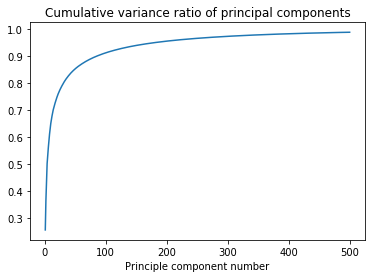

Raw
Train Accurate: 0.6003
Test Accurate: 0.5935 

K: 1
Train Accurate: 0.5305
Test Accurate: 0.5185 

K: 3
Train Accurate: 0.5733
Test Accurate: 0.566 

K: 5
Train Accurate: 0.5786
Test Accurate: 0.572 

K: 8
Train Accurate: 0.5837
Test Accurate: 0.5845 

K: 16
Train Accurate: 0.5984
Test Accurate: 0.5835 

K: 34
Train Accurate: 0.6214
Test Accurate: 0.62 

K: 94
Train Accurate: 0.598
Test Accurate: 0.5915 



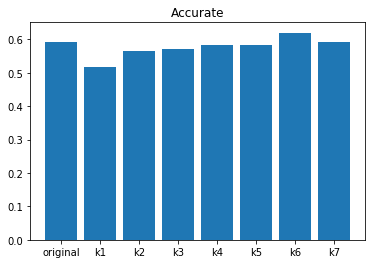

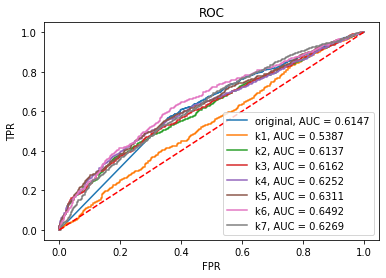

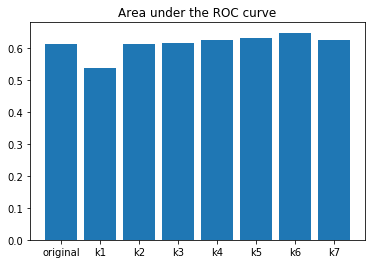

In [3]:
# %% Q2
# plot roc data
def plot_roc(roc_dict):
    plt.title('ROC')
    i = 0
    for k,v in roc_dict.items():
        fpr,tpr,auc = v['fpr'],v['tpr'],v['auc']
        if k == 'original':
            plt.plot(fpr, tpr,label='original, AUC = %0.4f'% auc)
        else:
            i+=1
            plt.plot(fpr, tpr,label='k'+str(i)+', AUC = %0.4f'% auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

# Separate the input and labels from the dataset and flatten the input
def loadPCAData(data):
    x = data.normal_images.numpy().transpose(0,2,3,1).reshape(data.length,-1)
    y = np.array(data.labels)
    return x,y

class PCA(PCA):
    '''PCA
    Redefining the PCA class, inherited from the parent PCA.
    Add several problem-specific functions to PCA.
    '''
    def plot_eigenfaces(self,w=32,h=32,c=3):
        eigenfaces = self.components_.reshape(-1,w,h,c)
        eigenface_titles = ["feature %d" %
                                  i for i in range(eigenfaces.shape[0])]
        self.__plot_gallery(eigenfaces,eigenface_titles,eigen = True)

    def __plot_gallery(self, images, titles=None, n_row=3, n_col=4, eigen = False):
        """Helper function to plot a gallery of portraits"""
        plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
        plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
        for i in range(n_row * n_col):
            plt.subplot(n_row, n_col, i + 1)
            if eigen == True:
                plt.imshow(np.clip(images[i]*20,0,1))
            else:
                plt.imshow((images[i]+1)/2)
            if titles:
                plt.title(titles[i], size=12)
            plt.xticks(())
            plt.yticks(())
        plt.show()

    def plot_curve(self, data, title = None, xlabel = None, ylabel = None):
        plt.plot(range(1, data.shape[0] + 1), data)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def getFeature(self,data,k):
        feature_k = self.components_[:k]
        feature_data = data.dot(feature_k.T)
        return feature_data

    def getReconstruct(self,data,k):
        feature_data = self.getFeature(data,k)
        reconstruct_data = feature_data.dot(self.components_[:k])
        return reconstruct_data

    def plot_image(self,images,w,h,c,title = None):
        images_recovery = images.reshape(images.shape[0],w,h,c)[:5]
        scale = max(abs(images_recovery.max()),abs(images_recovery.min()))
        self.__plot_gallery(images_recovery/scale,n_row=1,n_col=5)

    def getSample_k(self,num = 7):
        variance_ratio = np.cumsum(self.explained_variance_ratio_)
        sellect_ratio = np.linspace(variance_ratio.min(),1,num+2)[1:-1]
        sellect_feature_index = [np.where(variance_ratio<=ratio)[0][-1] for ratio in sellect_ratio]
        return sellect_feature_index

class Multiclassifier():
    '''Multiclassifier
    A collection of classifiers for easy invocation
    '''
    def __init__(self,train_raw,train_y,test_raw,test_y,print_ROC = False):
        self.print_ROC = print_ROC
        self.train_raw = train_raw
        self.train_y = train_y
        self.test_raw = test_raw
        self.test_y = test_y

    def updateDataset(self,train_x,test_x):
        self.train_x = train_x
        self.test_x = test_x

    def NBclassifier(self):
        tic = time.time()
        model = GaussianNB().fit(self.train_x, self.train_y)
        self.train_time = time.time() - tic
        tic = time.time()
        _ = model.predict(self.test_x)
        self.test_time = time.time() - tic
        train_accurate = accuracy_score(self.train_y, model.predict(self.train_x))
        test_accurate = accuracy_score(self.test_y, model.predict(self.test_x))
        test_pre_proba = model.predict_proba(self.test_x)

        print('Train Accurate:', train_accurate)
        print('Test Accurate:', test_accurate,'\n')

        if self.print_ROC:
            fpr,tpr,_ = roc_curve(self.test_y, test_pre_proba[:,1])
            roc_auc = auc(fpr, tpr)
            self.roc_dict = {'fpr':fpr,'tpr':tpr,'auc':roc_auc}

        confusion = [model.predict(self.test_x),self.test_y]
        return train_accurate,test_accurate,confusion

    def NBclassifier_raw(self):
        tic = time.time()
        model = GaussianNB().fit(self.train_raw, self.train_y)
        self.train_time = time.time() - tic
        tic = time.time()
        _ = model.predict(self.test_raw)
        self.test_time = time.time() - tic
        train_accurate = accuracy_score(self.train_y, model.predict(self.train_raw))
        test_accurate = accuracy_score(self.test_y, model.predict(self.test_raw))
        test_pre_proba = model.predict_proba(self.test_raw)

        print('Train Accurate:', train_accurate)
        print('Test Accurate:', test_accurate,'\n')

        if self.print_ROC:
            fpr,tpr,_ = roc_curve(self.test_y, test_pre_proba[:,1])
            roc_auc = auc(fpr, tpr)
            self.roc_dict = {'fpr':fpr,'tpr':tpr,'auc':roc_auc}
        confusion = [model.predict(self.test_raw), self.test_y]
        return train_accurate,test_accurate,confusion

    def LRclassifier(self):
        tic = time.time()
        model =LogisticRegression(solver='sag',multi_class='multinomial',tol=0.5).fit(self.train_x, self.train_y)
        self.train_time = time.time() - tic
        tic = time.time()
        _ = model.predict(self.test_x)
        self.test_time = time.time() - tic
        train_accurate = accuracy_score(self.train_y, model.predict(self.train_x))
        test_accurate = accuracy_score(self.test_y, model.predict(self.test_x))
        test_pre_proba = model.predict_proba(self.test_x)

        print('Train Accurate:', train_accurate)
        print('Test Accurate:', test_accurate,'\n')

        confusion = [model.predict(self.test_x),self.test_y]
        return train_accurate,test_accurate,confusion

    def LRclassifier_raw(self):
        tic = time.time()
        model =LogisticRegression(solver='sag',multi_class='multinomial',tol=0.5).fit(self.train_raw, self.train_y)
        self.train_time = time.time() - tic
        tic = time.time()
        _ = model.predict(self.test_raw)
        self.test_time = time.time() - tic
        train_accurate = accuracy_score(self.train_y, model.predict(self.train_raw))
        test_accurate = accuracy_score(self.test_y, model.predict(self.test_raw))
        test_pre_proba = model.predict_proba(self.test_raw)

        print('Train Accurate:', train_accurate)
        print('Test Accurate:', test_accurate,'\n')

        confusion = [model.predict(self.test_raw), self.test_y]
        return train_accurate,test_accurate,confusion

# Part1: get training dataset
train_x,train_y = loadPCAData(dataset['train']['raw'])
test_x,test_y = loadPCAData(dataset['test']['raw'])

# Part2: PCA fit and get a set of k choices
pca = PCA(n_components = 500, svd_solver='randomized', whiten=True)
pca = pca.fit(train_x)
#pca.plot_eigenfaces()
pca.plot_curve(np.cumsum(pca.explained_variance_ratio_),
            'Cumulative variance ratio of principal components',
            'Principle component number')
sellect_feature_index = pca.getSample_k(7)

# Part3: train with classifier
mode = Multiclassifier(train_x,train_y,test_x,test_y,print_ROC = True)
test_acc_list = list()
roc_dict = dict()
print('Raw')
_,test_acc,_ = mode.NBclassifier_raw()
test_acc_list.append(test_acc)
roc_dict['original'] = mode.roc_dict
for i in sellect_feature_index:
    k = i+1
    print('K:',k)
    # show image reconstruction
    #train_x_recon = pca.getReconstruct(train_x,k)
    #pca.plot_image(train_x, 32, 32, 3)
    #pca.plot_image(train_x_recon, 32, 32, 3)
    # updata k
    mode.updateDataset(pca.getFeature(train_x,k),pca.getFeature(test_x,k))
    _,test_acc,_ = mode.NBclassifier()
    test_acc_list.append(test_acc)
    roc_dict[k] = mode.roc_dict

# Part4: plot Accurate, ROC and AUC
plt.bar(['original','k1','k2','k3','k4','k5','k6','k7'],test_acc_list)
plt.title('Accurate')
plt.show()
plot_roc(roc_dict)
plt.bar(['original','k1','k2','k3','k4','k5','k6','k7'],[v['auc'] for k,v in roc_dict.items()])
plt.title('Area under the ROC curve')
plt.show()

### Question 3: Noisy data and multiclass classification (6 marks)

#### Noisy **CatDog** subset.

3a. Repeat 2a, 2b, and 2c on the noisy version of CatDog subset. Show the bar graph and compare it with that in 2c above. 

#### Multiclass classification using the original CIFAR-10 dataset (all 10 classes)

3b. Apply PCA on the training set to reduce the dimensionality. You need to study at least **three** different values for the reduced dimensionality. Explain your choice.

3c. Train nine classifers: **four Naive Bayes** classifiers(one on the original features, and three on PCA features with three different dimensions in 3b); **four Logistic Regression** classifiers (one on the original features, and three on PCA features with three different dimensions in 3b); and one **Convoluational Neural Network** as defined in the [pytorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

3d. Evalaute the nine classifiers on the test set. Summarise the **classification accuracy**, **total training time**, and **total test time** using three bar graphs.

3e. Show the confusion matrix for these nine classifiers (see Lab 8 - 1.4).

3f. Describe **at least three** interesting observations from the evaluation results above. Each observation should have **3-5 sentences**. 

#### Answer PART-1 (Noisy CatDog subset)

Train Accurate: 0.5971
Test Accurate: 0.592 

K: 1
Train Accurate: 0.5296
Test Accurate: 0.5165 

K: 3
Train Accurate: 0.5672
Test Accurate: 0.574 

K: 5
Train Accurate: 0.5772
Test Accurate: 0.578 

K: 8
Train Accurate: 0.5839
Test Accurate: 0.5915 

K: 16
Train Accurate: 0.5983
Test Accurate: 0.599 

K: 34
Train Accurate: 0.6083
Test Accurate: 0.6185 

K: 94
Train Accurate: 0.6012
Test Accurate: 0.589 



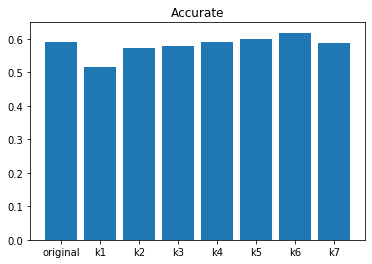

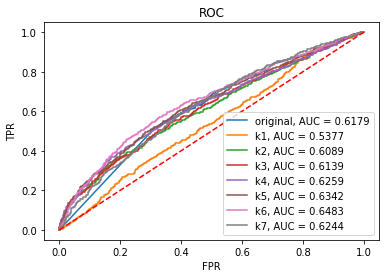

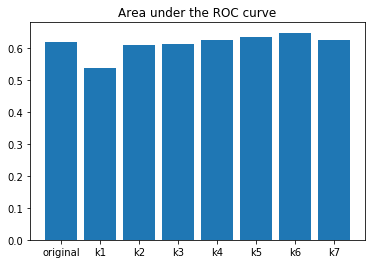

In [4]:
# %% Noise
# Part1: get training dataset
train_x,train_y = loadPCAData(dataset['train']['noise'])
test_x,test_y = loadPCAData(dataset['test']['noise'])

# Part2: PCA fit and get a set of k
pca = PCA(n_components = 500, svd_solver='randomized', whiten=True)
pca = pca.fit(train_x)

# Part3: train with classifier
mode = Multiclassifier(train_x,train_y,test_x,test_y,print_ROC = True)
test_acc_list = list()
roc_dict = dict()
_,test_acc,_ = mode.NBclassifier_raw()
test_acc_list.append(test_acc)
roc_dict['original'] = mode.roc_dict
for i in sellect_feature_index:
    k = i+1
    print('K:',k)
    # image reconstruction
    #train_x_recon = pca.getReconstruct(train_x,k)
    #pca.plot_image(train_x, 32, 32, 3)
    #pca.plot_image(train_x_recon, 32, 32, 3)
    # updata k
    mode.updateDataset(pca.getFeature(train_x,k),pca.getFeature(test_x,k))
    _,test_acc,_ = mode.NBclassifier()
    test_acc_list.append(test_acc)
    roc_dict[k] = mode.roc_dict

# Part4: plot Accurate, ROC and AUC
plt.bar(['original','k1','k2','k3','k4','k5','k6','k7'],test_acc_list)
plt.title('Accurate')
plt.show()
plot_roc(roc_dict)
plt.bar(['original','k1','k2','k3','k4','k5','k6','k7'],[v['auc'] for k,v in roc_dict.items()])
plt.title('Area under the ROC curve')
plt.show()

#### Answer PART-2 (Multiclass classification)
3b. Same as the method of taking the k value above, the k value is selected according to the proportion of the cumulative variance.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
4 Naive Bayes
Train Accurate: 0.28472
Test Accurate: 0.2976 

K: 2
Train Accurate: 0.20326
Test Accurate: 0.214 

K: 9
Train Accurate: 0.32724
Test Accurate: 0.3336 

K: 40
Train Accurate: 0.36966
Test Accurate: 0.3663 

4 Logistic Regression
Train Accurate: 0.40074
Test Accurate: 0.3648 

K: 2
Train Accurate: 0.2028
Test Accurate: 0.2063 

K: 9
Train Accurate: 0.28224
Test Accurate: 0.2779 

K: 40
Train Accurate: 0.31996
Test Accurate: 0.3119 

[1,   200] loss: 2.305
[2,   200] loss: 2.300
[3,   200] loss: 2.288
[4,   200] loss: 2.247
[5,   200] loss: 2.153
[6,   200] loss: 2.046
[7,   200] loss: 1.954
[8,   200] loss: 1.892
[9,   200] loss: 1.830
[10,   200] loss: 1.773
[11,   200] loss: 1.725
[12,   200] loss: 1.680
[13,   200] loss: 1.637
[14,   200] loss: 1.598
[15,   200] loss: 1.562
[16,   200] loss: 1.532
[17,   200] loss: 1.505

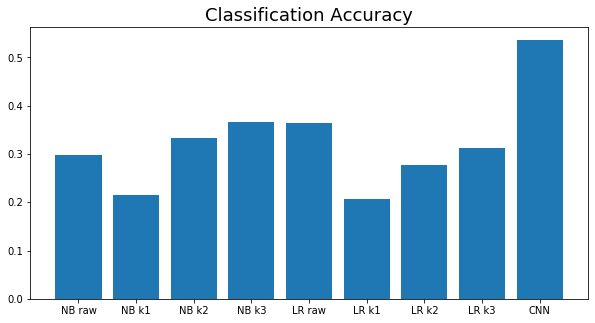

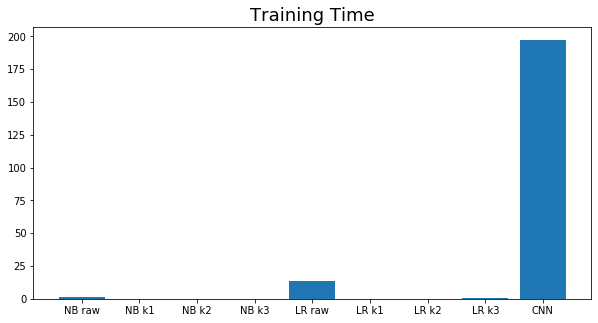

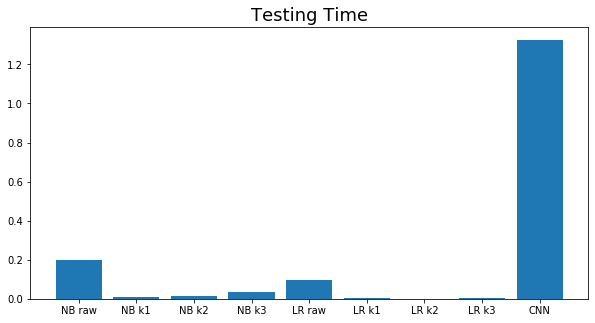

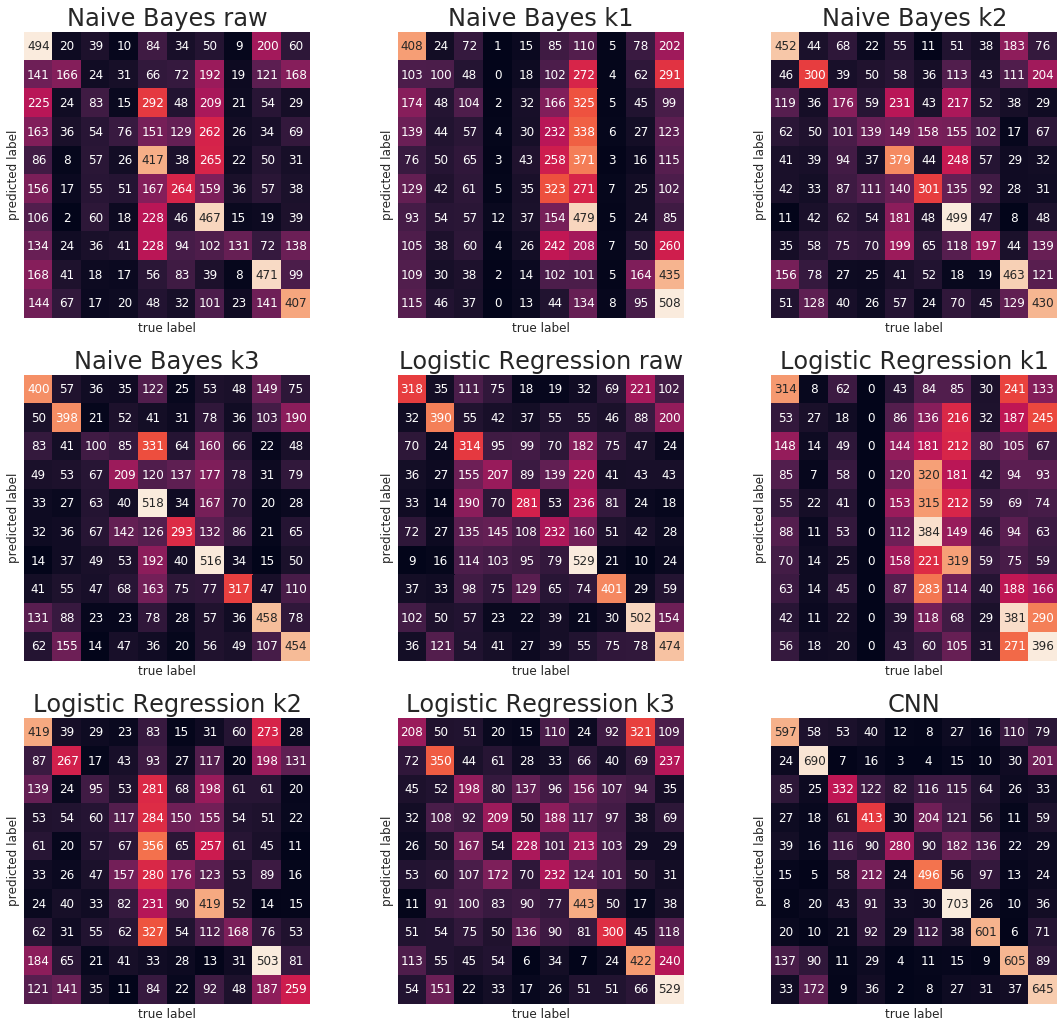

In [5]:
# %% 10 classifier
# set transform for dataset
transform = {
    'raw': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'noise': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + SCALE * NOISE),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
data_source = {'train':True,'test':False}
data_process = ('raw','noise')

dataset = {k: {p: CIFAR10Dataset(classes, root='./data', train=v,
                    download=True, transform=transform[p]) for p in data_process} for k,v in data_source.items()}

loader = {k: {p: torch.utils.data.DataLoader(dataset[k][p], batch_size=BATCH,
                    shuffle=False, num_workers=2) for p in data_process} for k in data_source}
'''
images, labels = next(iter(loader['train']['raw']))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH)))

images, labels = next(iter(loader['train']['noise']))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH)))
'''
confusion_matrix_collect = list()
accuracy_collect = list()
train_time_collect = list()
test_time_collect = list()
#%% 4 Naive Bayes
# Part1: get training dataset
train_x,train_y = loadPCAData(dataset['train']['raw'])
test_x,test_y = loadPCAData(dataset['test']['raw'])

# Part2: PCA fit and get a set of k
pca = PCA(n_components = 500, svd_solver='randomized', whiten=True)
pca = pca.fit(train_x)
sellect_feature_index = pca.getSample_k(3)

# Part3: train with classifier
print('4 Naive Bayes')
mode = Multiclassifier(train_x,train_y,test_x,test_y)
test_acc_list = list()

_,test_acc,confusion = mode.NBclassifier_raw()
test_acc_list.append(test_acc)
# collect data
confusion_matrix_collect.append(confusion)
accuracy_collect.append(test_acc)
train_time_collect.append(mode.train_time)
test_time_collect.append(mode.test_time)
for i in sellect_feature_index:
    k = i+1
    print('K:',k)
    # image reconstruction
    #train_x_recon = pca.getReconstruct(train_x,k)
    #pca.plot_image(train_x, 32, 32, 3)
    #pca.plot_image(train_x_recon, 32, 32, 3)
    # updata k
    mode.updateDataset(pca.getFeature(train_x,k),pca.getFeature(test_x,k))
    _,test_acc,confusion = mode.NBclassifier()
    test_acc_list.append(test_acc)
    # collect data
    confusion_matrix_collect.append(confusion)
    accuracy_collect.append(test_acc)
    train_time_collect.append(mode.train_time)
    test_time_collect.append(mode.test_time)

# Part4: plot Accurate, ROC and AUC
#plt.bar(['original','k1','k2','k3'],test_acc_list)
#plt.title('4 Naive Bayes Accurate')
#plt.show()

#%% 4 Logistic Regression
# PCA
# Part1: get training dataset
train_x,train_y = loadPCAData(dataset['train']['raw'])
test_x,test_y = loadPCAData(dataset['test']['raw'])

# Part2: PCA fit and get a set of k
pca = PCA(n_components = 500, svd_solver='randomized', whiten=True)
pca = pca.fit(train_x)
#sellect_feature_index = pca.getSample_k(3)

# Part3: train with classifier
print('4 Logistic Regression')
mode = Multiclassifier(train_x,train_y,test_x,test_y)
test_acc_list = list()
_,test_acc,confusion = mode.LRclassifier_raw()
test_acc_list.append(test_acc)
# collect data
confusion_matrix_collect.append(confusion)
accuracy_collect.append(test_acc)
train_time_collect.append(mode.train_time)
test_time_collect.append(mode.test_time)
for i in sellect_feature_index:
    k = i+1
    print('K:',k)
    # image reconstruction
    #train_x_recon = pca.getReconstruct(train_x,k)
    #pca.plot_image(train_x, 32, 32, 3)
    #pca.plot_image(train_x_recon, 32, 32, 3)
    # updata k
    mode.updateDataset(pca.getFeature(train_x,k),pca.getFeature(test_x,k))
    _,test_acc,confusion = mode.LRclassifier()
    test_acc_list.append(test_acc)
    # collect data
    confusion_matrix_collect.append(confusion)
    accuracy_collect.append(test_acc)
    train_time_collect.append(mode.train_time)
    test_time_collect.append(mode.test_time)

# Part4: plot Accurate, ROC and AUC
#plt.bar(['original','k1','k2','k3'],test_acc_list)
#plt.title('4 Logistic Regression Accurate')
#plt.show()

# %% 1 CNN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

trainloader = loader['train']['raw']
testloader = loader['test']['raw']

net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

tic = time.time()
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
print('Finished Training\n')
print('1 CNN')
train_time_collect.append(time.time() - tic)
correct = 0
total = 0
confusion = [torch.zeros(len(testloader),BATCH) for i in range(2)]
i = 0
tic = time.time()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        confusion[0][i,:] = predicted.view(-1)
        confusion[1][i,:] = labels.view(-1)
        i += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_time_collect.append(time.time()-tic)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
confusion = [confusion[i].view(-1).numpy() for i in range(2)]
confusion_matrix_collect.append(confusion)
accuracy_collect.append(correct / total)
# %% plot the classification accuracy, total training time, and total test time
catagory = ['NB','LR']
title = ['raw','k1','k2','k3']
titles = [c+' '+t for c in catagory for t in title] + ['CNN']
plt.figure(figsize=(10, 5))
plt.bar(titles,accuracy_collect)
plt.title("Classification Accuracy",size = 18)
plt.show()
plt.figure(figsize=(10, 5))
plt.bar(titles,train_time_collect)
plt.title("Training Time",size = 18)
plt.show()
plt.figure(figsize=(10, 5))
plt.bar(titles,test_time_collect)
plt.title("Testing Time",size = 18)
plt.show()

# %% confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

catagory = ['Naive Bayes','Logistic Regression']
title = ['raw','k1','k2','k3']
titles = [c+' '+t for c in catagory for t in title] + ['CNN']
n_row = n_col = 3
#plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.figure(figsize=(5 * n_col, 5 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.2)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    mat = confusion_matrix(*confusion_matrix_collect[i])
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels='', yticklabels='')
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title(titles[i], size=24)
    plt.xticks(())
    plt.yticks(())
plt.show()

3f. The noised data will be slightly reduced in terms of accuracy. Neural networks have the highest accuracy, and logistic regression and Naive Bayes have similar accuracy. And, in logistic regression and Naive Bayes, as the eigenvalues increase, the accuracy gradually improves

### Question 4: Denoising Autoencoder (4 marks)

This question uses both the original and noisy CIFAR-10 datasets (all 10 classes).

Read about denoising autoencoder at [Wikepedia](https://en.wikipedia.org/wiki/Autoencoder#Denoising_autoencoder_(DAE)) and this [short introduction](https://towardsdatascience.com/denoising-autoencoders-explained-dbb82467fc2) or any other sources you like.

4a. Modify the autoencoder architecture in Lab 7 so that it takes colour images as input (i.e., 3 input channels). 

4b. **Training**: feed the **noisy training images** as input to the autoencoder in 4a; use a loss function that computes the reconstruction error between the **output of the autoencoder** and the respective **original images**.

4c. **Testing**: evaluate the autoencoder trained in 4b on the test datasets (feed noisy images in and compute reconstruction errors on original clean images. Find the **worstly denoised** 30 images (those with the largest reconstruction errors) in the test set and show them in pairs with the original images (60 images to show in total).

4d. Choose at least two hyperparameters to vary. Study **at least three different choices** for each hyperparameter. When varying one hyperparameter, all the other hyperparameters can be fixed. Visualise the performance sensitivity with respect to these hyperparameters.

4e. Describe **at least two** interesting observations from the evaluation results above. Each observation should have **3-5 sentences**. 

#### Answer PART-1 (Training & Testing )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[1,   200] loss: 0.113
[2,   200] loss: 0.042
[3,   200] loss: 0.032
[4,   200] loss: 0.028
[5,   200] loss: 0.025
Finished Training


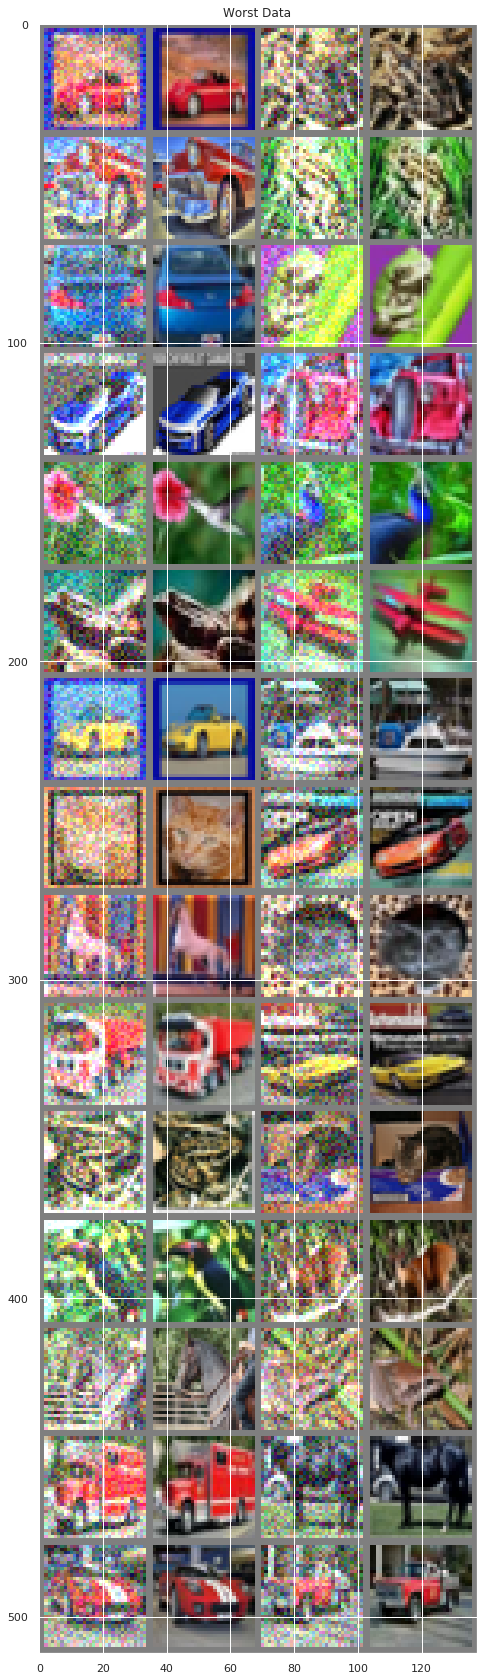

In [6]:
# %% Q4
# set transform for dataset
transform = {
    'raw': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'noise': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + SCALE * NOISE),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
data_source = {'train':True,'test':False}
data_process = ('raw','noise')

# load 4 different datasets:
# train with raw data, train with noise data
# test with raw data, test with noise data
dataset = {k: {p: CIFAR10Dataset(classes, root='./data', train=v,
                    download=True, transform=transform[p]) for p in data_process} for k,v in data_source.items()}

loader = {k: {p: torch.utils.data.DataLoader(dataset[k][p], batch_size=BATCH,
                    shuffle=False, num_workers=2) for p in data_process} for k in data_source}

# %%
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            #nn.Sigmoid()  #to range [0, 1]
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


trainloader_noise = loader['train']['noise']
trainloader_raw = loader['train']['raw']

net = Autoencoder()
net.to(device)

def trainNet(net,trainloader_raw,trainloader_noise,lr = 0.001, max_epoch = 5):
    criterion = nn.MSELoss()
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(max_epoch):
        running_loss = 0.0
        data_iter = iter(trainloader_raw)
        for i,data_noise in enumerate(trainloader_noise,0):
            data_raw = next(data_iter)
            inputs_raw = data_raw[0].to(device)
            inputs_noise = data_noise[0].to(device)
            optimizer.zero_grad()
            recon = net(inputs_noise)
            loss = criterion(recon, inputs_raw)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0
    print('Finished Training')

trainNet(net,trainloader_raw,trainloader_noise,lr = 0.001,max_epoch = 5)

testloader_noise = loader['test']['noise']
testloader_raw = loader['test']['raw']


# collect loss
loss = torch.zeros(len(testloader_noise),BATCH)
with torch.no_grad():
    criterion = nn.MSELoss()
    data_iter = iter(testloader_raw)
    for i,data_noise in enumerate(testloader_noise,0):
        data_raw = next(data_iter)
        inputs_raw = data_raw[0].to(device)
        inputs_noise = data_noise[0].to(device)
        recon = net(inputs_noise)
        for j in range(len(inputs)):
            loss[i,j] = criterion(inputs_noise[j],recon[j])

top_list = loss.view(-1).topk(30)[-1]
worst_data = torch.zeros(30*2,*IMAGE_SIZE)
l = 0
for index in top_list:
    worst_data[l] = dataset['test']['noise'].normal_images[index]
    worst_data[l+1] = dataset['test']['raw'].normal_images[index]
    l += 2
imshow(torchvision.utils.make_grid(worst_data,nrow=4),title = 'Worst Data',size = (10,30))

#### Answer PART-2 (hyperparameter)

lr as hyperparameters
[1,   200] loss: 0.213
[2,   200] loss: 0.098
Finished Training
[1,   200] loss: 1.208
[2,   200] loss: 1.212
Finished Training
[1,   200] loss: 1.196
[2,   200] loss: 1.187
Finished Training

 max_epoch as hyperparameters
[1,   200] loss: 0.088
[2,   200] loss: 0.036
Finished Training
[1,   200] loss: 0.097
[2,   200] loss: 0.036
[3,   200] loss: 0.029
[4,   200] loss: 0.026
Finished Training
[1,   200] loss: 0.094
[2,   200] loss: 0.040
[3,   200] loss: 0.029
[4,   200] loss: 0.030
[5,   200] loss: 0.024
[6,   200] loss: 0.022
Finished Training


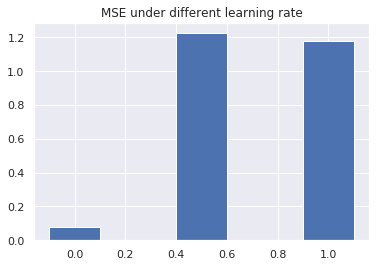

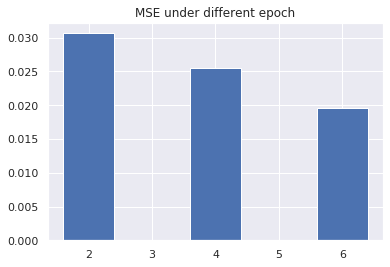

In [10]:
def MSE(net,testloader_raw,testloader_noise):
    loss = 0
    with torch.no_grad():
        data_iter = iter(testloader_raw)
        for i,data_noise in enumerate(testloader_noise,0):
            data_raw = next(data_iter)
            inputs_raw = data_raw[0].to(device)
            inputs_noise = data_noise[0].to(device)
            recon = net(inputs_noise)
            criterion = nn.MSELoss()
            loss += criterion(recon, inputs_raw)
    return loss/len(testloader_noise)

def hyperparametersTest(lr,max_epoch):
    trainloader_noise = loader['train']['noise']
    trainloader_raw = loader['train']['raw']
    net = Autoencoder()
    net.to(device)
    trainNet(net,trainloader_raw,trainloader_noise,lr = lr,max_epoch = max_epoch)
    testloader_noise = loader['test']['noise']
    testloader_raw = loader['test']['raw']
    MSE_loss = MSE(net,testloader_raw,testloader_noise)
    return MSE_loss.item()

print("lr as hyperparameters")
lr = [0.0001, 0.5, 1]
MSE_lr = [hyperparametersTest(lr = p,max_epoch = 2) for p in lr]
print("\n max_epoch as hyperparameters")
max_epoch = [2,4,6]
MSE_epoch = [hyperparametersTest(lr = 0.01,max_epoch = e) for e in max_epoch]

plt.bar(lr,MSE_lr,width=0.2)
plt.title("MSE under different learning rate")
plt.show()

plt.bar(max_epoch,MSE_epoch)
plt.title("MSE under different epoch")
plt.show()

4e. If the learning rate is too small, gradient descent is slow and convergence is slow. But when the learning rate is too large, the function may not converge at all, and the MSE is getting larger and larger. So choosing a reasonable learning rate is crucial.

In general, epoch needs to be enough to produce good results. But when the epoch is too large, the network cannot learn anything in the later stages.

